In [2]:
%load_ext hamilton.plugins.jupyter_magic

/Users/stefankrawczyk/.pyenv/versions/knowledge_retrieval-py39/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


# Example pipeline

This is a simple example of a pipeline that reads data from a file and a database, joins them, fits a model, and saves the model to a file and the joined data to a database. The pipeline does not import open lineage, and doesn't need to know about it. The salient point is that metadata is exposed by the data loading and data
saving functions.  This is what is used to populated OpenLineage events.

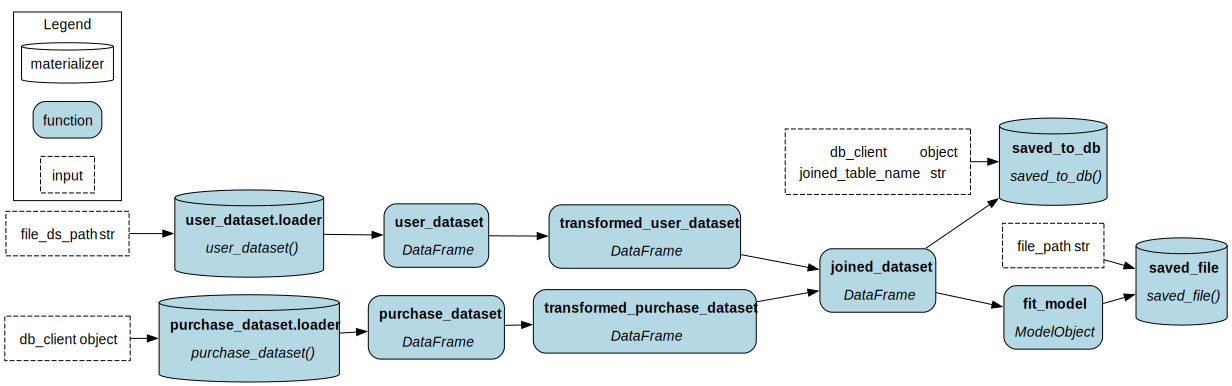

In [3]:
%%cell_to_module pipeline --display

import pickle
from typing import Tuple

import pandas as pd

from hamilton.function_modifiers import dataloader, datasaver
from hamilton.io import utils

@dataloader()
def user_dataset(file_ds_path: str) -> Tuple[pd.DataFrame, dict]:
    df = pd.read_csv(file_ds_path)
    return df, utils.get_file_and_dataframe_metadata(file_ds_path, df)


@dataloader()
def purchase_dataset(db_client: object) -> Tuple[pd.DataFrame, dict]:
    query = "SELECT * FROM purchase_data"
    df = pd.read_sql(query, con=db_client)
    metadata = {
        "sql_metadata": {"query": query, "table_name": "purchase_data", "database": "sqlite"}
    }
    metadata.update(utils.get_dataframe_metadata(df))
    return df, metadata


def transformed_user_dataset(user_dataset: pd.DataFrame) -> pd.DataFrame:
    return user_dataset


def transformed_purchase_dataset(purchase_dataset: pd.DataFrame) -> pd.DataFrame:
    return purchase_dataset


def joined_dataset(
    transformed_user_dataset: pd.DataFrame, transformed_purchase_dataset: pd.DataFrame
) -> pd.DataFrame:
    joined = pd.merge(transformed_user_dataset,
                      transformed_purchase_dataset,
                      left_on="id", right_on="user_id")
    del joined["id_x"]
    del joined["id_y"]
    return joined


class ModelObject:
    def __init__(self):
        pass

    def predict(self, data):
        return data + 1


def fit_model(joined_dataset: pd.DataFrame) -> ModelObject:
    # model = ...
    return ModelObject()


@datasaver()
def saved_file(fit_model: ModelObject, file_path: str) -> dict:
    with open(file_path, "wb") as f:
        pickle.dump(fit_model, f)
    return utils.get_file_metadata(file_path)


@datasaver()
def saved_to_db(joined_dataset: pd.DataFrame, db_client: object, joined_table_name: str) -> dict:
    joined_dataset.to_sql(joined_table_name, con=db_client, index=False, if_exists="replace")
    # raise ValueError("Hi")
    metadata = utils.get_sql_metadata(joined_table_name, joined_dataset)
    metadata.update(utils.get_dataframe_metadata(joined_dataset))
    return metadata

# Create OpenLineage client

In [4]:
from openlineage.client import OpenLineageClient
from openlineage.client.transport.file import FileConfig, FileTransport

# if you don't have a running OpenLineage server, you can use the FileTransport
file_config = FileConfig(
    log_file_path="pipeline.json",
    append=True,
)

# if you have a running OpenLineage server, e.g. marquez, uncomment this line.
# client = OpenLineageClient(url="http://localhost:9000")
client = OpenLineageClient(transport=FileTransport(file_config))

# Create Hamilton DAG with OpenLineage Adapter

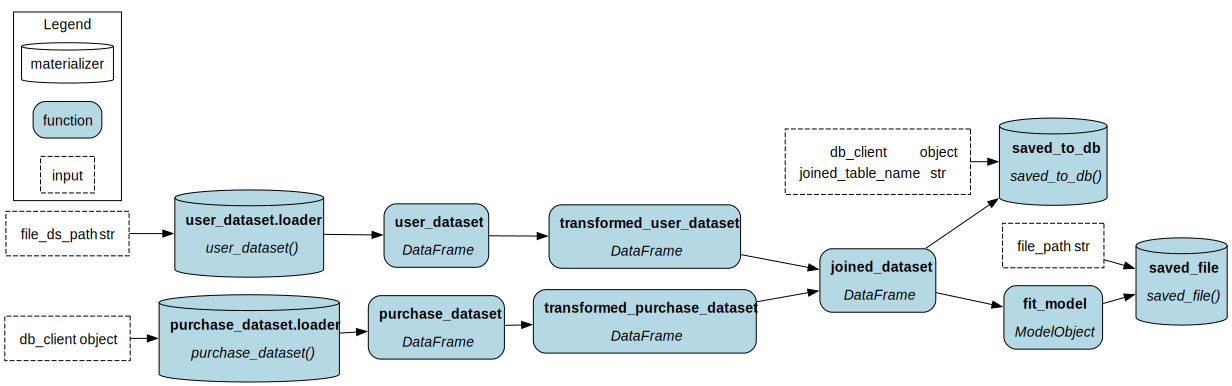

In [5]:
from hamilton.plugins import h_openlineage
from hamilton import driver

import pipeline
ola = h_openlineage.OpenLineageAdapter(client, "demo_namespace", "my_hamilton_job")

# create the DAG
dr = driver.Builder().with_modules(pipeline).with_adapters(ola).build()
# display the graph
dr.display_all_functions()

In [6]:
# create inputs to run the DAG
import sqlite3
db_client = sqlite3.connect("purchase_data.db")

# execute & emit lineage
result = dr.execute(
    ["saved_file", "saved_to_db"],
    inputs={
        "db_client": db_client,
        "file_ds_path": "data.csv",
        "file_path": "model.pkl",
        "joined_table_name": "joined_data",
    },
)
# close the DB
db_client.close()